In [30]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import matplotlib.pyplot as plt

# DATA ANALYSIS

In [31]:
df = pd.read_csv('dataset/mock_kaggle.csv', parse_dates=['data'])
print(df.shape)

df['id'] = 1
df.rename(columns={'data': 'timestamp'}, inplace=True)
df.tail()

(937, 4)


,timestamp,venda,estoque,preco,id
932,2016-07-27,98,3179,2.39,1
933,2016-07-28,108,3071,2.39,1
934,2016-07-29,128,4095,2.39,1
935,2016-07-30,270,3825,2.39,1
936,2016-07-31,183,3642,2.39,1


In [32]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df[:900],
    id_column="id",
    timestamp_column="timestamp"
)

predictor = TimeSeriesPredictor(
    prediction_length=37,
    target="venda",
    eval_metric="RMSE",
    freq="D",
    known_covariates_names=["estoque", "preco"],
    path='model'
)

## TRAIN MODEL

In [33]:
predictor.fit(
    train_data,
    presets="best_quality",
    time_limit=900,
    num_val_windows=5,
)
predictor.delete_models(models_to_keep='best', dry_run=False)

Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to 'model'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.5.0: Wed May  1 20:16:51 PDT 2024; root:xnu-10063.121.3~5/RELEASE_ARM64_T8103
CPU Count:          8
GPU Count:          0
Memory Avail:       1.33 GB / 8.00 GB (16.6%)
Disk Space Avail:   27.61 GB / 228.27 GB (12.1%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'freq': 'D',
 'hyperparameters': 'default',
 'known_covariates_names': ['estoque', 'preco'],
 'num_val_windows': 5,
 'prediction_length': 37,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'venda',
 'time_limit': 900,
 'verbosity': 2}

train_data wi

AttributeError: 'TimeSeriesPredictor' object has no attribute 'save_space'

## LOAD MODEL

In [34]:
# model = predictor.load('model')

## INFER DATA

In [35]:
covariates = TimeSeriesDataFrame.from_data_frame(
    df[['id', 'timestamp', 'estoque', 'preco']], 
    timestamp_column="timestamp", 
    id_column="id"
)

forecast = predictor.predict(train_data, known_covariates=covariates)
forecast.head()

data with frequency 'None' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id timestamp                                                    
1       2016-06-25  208.126900  127.569456  169.851826  186.568106   
        2016-06-26  179.535002   98.677234  136.981695  159.545339   
        2016-06-27  104.041256   27.866424   60.745681   77.883215   
        2016-06-28   83.787902    5.106155   37.487800   54.625627   
        2016-06-29   89.201375    0.586413   38.853607   58.705617   

                           0.4         0.5         0.6         0.7  \
item_id timestamp                                                    
1       2016-06-25  202.428046  210.164628  236.085264  244.994495   
        2016-06-26  167.841133  178.757069  207.159268  222.498866   
        2016-06-27   92.608738  104.686380  127.697320  134.014720   
        2016-06-28   68.246646   83.156922  107.994762  115.315271   
        2016-06-29   72.502447   89.539065  116.383405  126.447652   

                           0.8         0.9  
item_id timestamp                           
1       2016-06-25  266.341439  313.412168  
        2016-06-26  236.586668  284.322095  
        2016-06-27  147.759429  180.893786  
        2016-06-28  130.969416  169.573995  
        2016-06-29  143.224999  190.989923

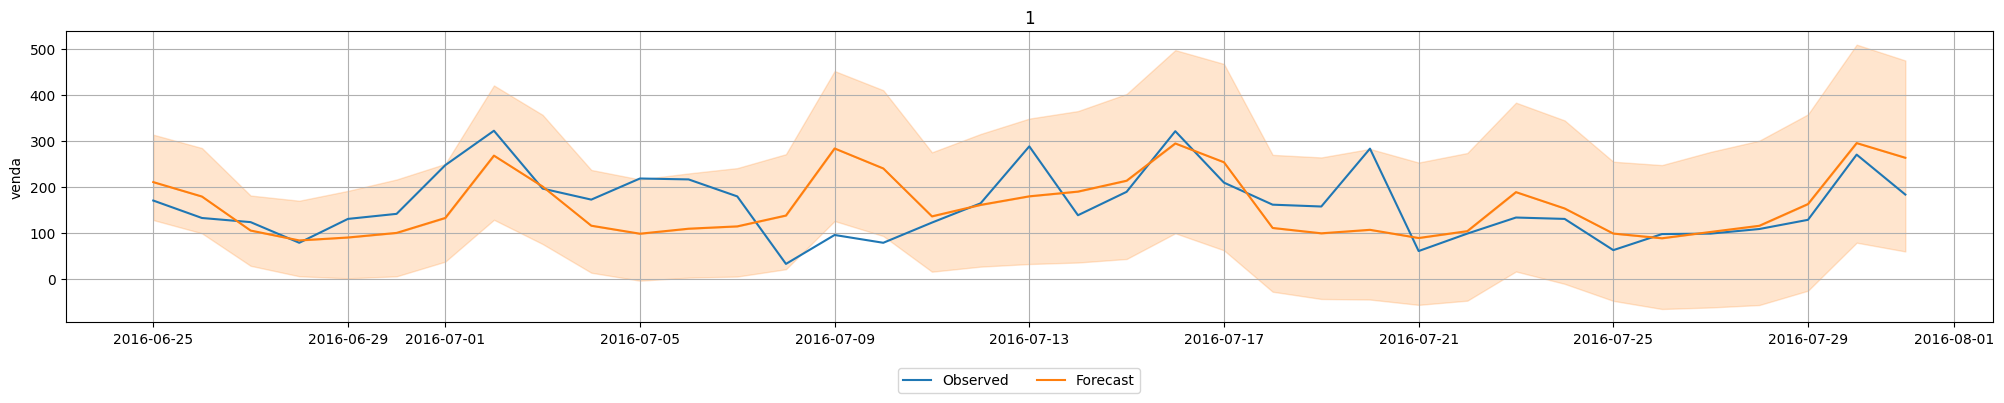

In [37]:
test_data = TimeSeriesDataFrame.from_data_frame(
    df[900:],
    id_column="id",
    timestamp_column="timestamp"
)

predictor.plot(test_data, forecast, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4)

In [36]:
predictor.evaluate(train_data)

data with frequency 'None' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


{'RMSE': -116.12843310336113}